In [4]:
%pip install matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, rows, cols, goal_state, trap_state, obstacle_states):
        self.rows = rows
        self.cols = cols
        self.goal = tuple(goal_state)
        self.trap = tuple(trap_state)
        self.obstacles = set(tuple(obs) for obs in obstacle_states)
        self.state = None

    def reset(self):
        self.state = (1, 1)

    def step(self, action):
        if self.state is None:
            raise ValueError("Call reset() before step().")

        proposed_state = self._get_next_state(self.state, action)

        if self._is_valid_state(proposed_state):
            self.state = proposed_state
        else:
            proposed_state = self.state

        reward = self._get_reward(self.state)
        done = self._is_terminal_state(self.state)

        return self.state, reward, done

    def _get_next_state(self, state, action):
        row, col = state
        moves = {
            "N": (row - 1, col),
            "S": (row + 1, col),
            "E": (row, col + 1),
            "W": (row, col - 1),
        }
        return moves.get(action, state)

    def _is_valid_state(self, state):
        row, col = state
        return (
            1 <= row <= self.rows
            and 1 <= col <= self.cols
            and state not in self.obstacles
        )

    def _is_terminal_state(self, state):
        return state == self.goal or state == self.trap

    def _get_reward(self, state):
        if state == self.goal:
            return 5
        elif state == self.trap:
            return -5
        elif (
            state[0] < 1 or state[1] < 1 or state[0] > self.rows or state[1] > self.cols
        ):
            return -1
        return 0

    def plot_grid(self, policy=None, plot_policy_flag=False):
        fig, ax = plt.subplots()
        self._draw_grid_lines(ax)
        self._draw_special_cells(ax)
        self._draw_agent(ax)
        if plot_policy_flag and policy is not None:
            self._draw_policy_arrows(ax, policy)
        self._finalize_plot(ax, title="GridWorld Environment")

    def _draw_grid_lines(self, ax):
        for i in range(1, self.rows):
            ax.axhline(i, color="k", linewidth=1)
        for j in range(1, self.cols):
            ax.axvline(j, color="k", linewidth=1)

    def _draw_special_cells(self, ax):
        ax.plot(
            self.goal[1] - 0.5,
            self.goal[0] - 0.5,
            "gs",
            markerfacecolor="g",
            markersize=30,
        )
        ax.plot(
            self.trap[1] - 0.5,
            self.trap[0] - 0.5,
            "rs",
            markerfacecolor="r",
            markersize=30,
        )
        for obs in self.obstacles:
            ax.plot(
                obs[1] - 0.5, obs[0] - 0.5, "ks", markerfacecolor="k", markersize=30
            )

    def _draw_agent(self, ax):
        if self.state:
            ax.plot(
                self.state[1] - 0.5,
                self.state[0] - 0.5,
                "bo",
                markerfacecolor="b",
                markersize=20,
            )

    def _draw_policy_arrows(self, ax, policy):
        direction_map = {
            0: (0, -0.3),  # West
            1: (0, 0.3),  # East
            2: (0.3, 0),  # South
            3: (-0.3, 0),  # North
        }
        for i in range(self.rows):
            for j in range(self.cols):
                cell = (i + 1, j + 1)
                if cell in self.obstacles or cell == self.goal or cell == self.trap:
                    continue
                action = policy[i, j]
                if action in direction_map:
                    dx, dy = direction_map[action]
                    ax.arrow(
                        j + 0.5,
                        i + 0.5,
                        dx,
                        dy,
                        head_width=0.1,
                        head_length=0.1,
                        fc="k",
                        ec="k",
                    )
        ax.set_title("Converged Policy")

    def _finalize_plot(self, ax, title):
        ax.set_xlim((0, self.cols))
        ax.set_ylim((self.rows, 0))
        ax.set_xticks(np.arange(1, self.cols + 1))
        ax.set_yticks(np.arange(1, self.rows + 1))
        ax.grid(True)
        ax.set_aspect("equal")
        ax.set_title(title)
        plt.show()

In [2]:
def get_state_id(coords, rows, cols):
    return (coords[0] - 1) * cols + coords[1]


def get_action_from_index(action_idx):
    return ["N", "S", "E", "W"][action_idx]


def choose_action(Q, state_id, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    return np.argmax(Q[state_id - 1])

def choose_action_softmax(Q, state_id, tau):
    preferences = Q[state_id - 1] / tau
    max_pref = np.max(preferences)
    exp_preferences = np.exp(preferences - max_pref)
    probabilities = exp_preferences / np.sum(exp_preferences)
    return np.random.choice(len(Q[state_id - 1]), p=probabilities)

def train_q_learning(
    env, num_episodes=100000, alpha=0.1, gamma=0.9, epsilon=0.1, seed=42, max_steps=None
):
    np.random.seed(seed)
    num_states = env.rows * env.cols
    num_actions = 4
    Q = 0.001 * np.random.rand(num_states, num_actions)

    if max_steps is None:
        max_steps = env.rows * env.cols * 10

    episode_steps = []

    for ep in range(num_episodes):
        env.reset()
        current_state = get_state_id(env.state, env.rows, env.cols)

        steps = 0
        for _ in range(max_steps):
            action_idx = choose_action(Q, current_state, epsilon)
            action = get_action_from_index(action_idx)

            next_coords, reward, done = env.step(action)
            next_state = get_state_id(next_coords, env.rows, env.cols)

            td_target = reward + gamma * np.max(Q[next_state - 1])
            td_error = td_target - Q[current_state - 1, action_idx]
            Q[current_state - 1, action_idx] += alpha * td_error

            current_state = next_state
            steps += 1

            if done:
                break

        episode_steps.append(steps)

    return Q, episode_steps

def train_q_softmax(
    env, num_episodes=100000, alpha=0.1, gamma=0.9, tau=1.0, seed=42, max_steps=None
):
    np.random.seed(seed)
    num_states = env.rows * env.cols
    num_actions = 4
    Q = 0.001 * np.random.rand(num_states, num_actions)

    if max_steps is None:
        max_steps = env.rows * env.cols * 10

    episode_steps = []

    for ep in range(num_episodes):
        env.reset()
        current_state = get_state_id(env.state, env.rows, env.cols)

        steps = 0
        for _ in range(max_steps):
            action_idx = choose_action_softmax(Q, current_state, tau)
            action = get_action_from_index(action_idx)

            next_coords, reward, done = env.step(action)
            next_state = get_state_id(next_coords, env.rows, env.cols)

            td_target = reward + gamma * np.max(Q[next_state - 1])
            td_error = td_target - Q[current_state - 1, action_idx]
            Q[current_state - 1, action_idx] += alpha * td_error

            current_state = next_state
            steps += 1

            if done:
                break

        episode_steps.append(steps)

    return Q, episode_steps

In [3]:
def extract_policy_and_value(Q, env):
    policy = np.zeros((env.rows, env.cols), dtype=int)
    value_function = np.zeros((env.rows, env.cols))

    for i in range(env.rows):
        for j in range(env.cols):
            coords = [i + 1, j + 1]
            state = get_state_id(coords, env.rows, env.cols)

            if tuple(coords) in env.obstacles:
                policy[i, j] = -1
                value_function[i, j] = 0
                continue

            policy[i, j] = np.argmax(Q[state - 1])
            value_function[i, j] = np.max(Q[state - 1])

    value_function[env.goal[0] - 1, env.goal[1] - 1] = 5
    value_function[env.trap[0] - 1, env.trap[1] - 1] = -5

    return policy, value_function


def plot_value_function(value_fn, env, title="Value Function", figsize=(6, 5), fontsize=14):
    plt.figure(figsize=figsize)
    plt.imshow(
        value_fn,
        cmap="hot",
        interpolation="nearest",
        origin="upper",
        extent=(0.5, env.cols + 0.5, env.rows + 0.5, 0.5),
    )
    plt.title(title)
    plt.colorbar()

    g_row, g_col = env.goal
    t_row, t_col = env.trap

    plt.text(
        g_col,
        g_row,
        "G",
        color="lime",
        ha="center",
        va="center",
        fontsize=fontsize,
        fontweight="bold",
    )
    plt.text(
        t_col,
        t_row,
        "T",
        color="red",
        ha="center",
        va="center",
        fontsize=fontsize,
        fontweight="bold",
    )

    plt.xticks(np.arange(1, env.cols + 1))
    plt.yticks(np.arange(1, env.rows + 1))
    plt.grid(False)
    plt.show()

In [6]:
def create_env(rows, cols, goal_state, trap_state, obstacle_states):
    return GridWorld(
        rows=rows,
        cols=cols,
        goal_state=goal_state,
        trap_state=trap_state,
        obstacle_states=obstacle_states,
    )

def moving_average(arr, window):
    return [np.mean(arr[i : i + window]) for i in range(0, len(arr), window)]

# Assignment Part 1 Setup

In [ ]:
n = 5
goal_state = [n, n]
trap_state = [3, 5]
obstacle_states = [
    [1, 4],
    [2, 2],
    [3, 3],
    [5, 3],
]

## Question 1: Final Value Function & Policy

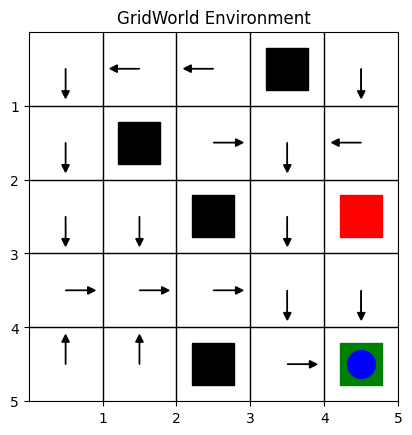

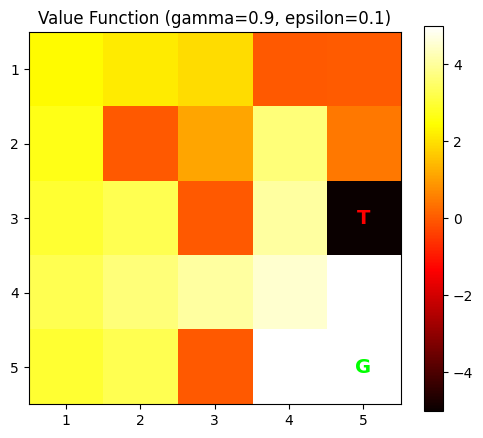

In [ ]:
q1_env = create_env(n, n, goal_state, trap_state, obstacle_states)

Q1, steps1 = train_q_learning(q1_env, gamma=0.9, epsilon=0.1)
policy1, value_fn1 = extract_policy_and_value(Q1, q1_env)

q1_env.plot_grid(policy1, plot_policy_flag=True)
print()
plot_value_function(value_fn1, q1_env, title="Value Function (gamma=0.9, epsilon=0.1)")

## Question 2: Varying Gamma

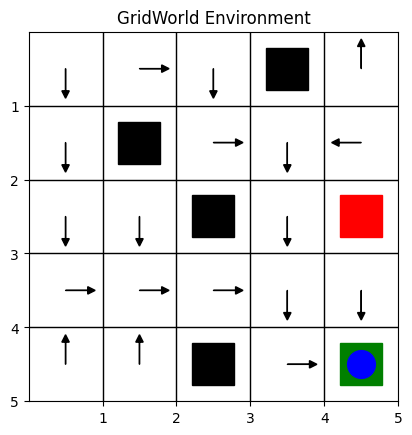

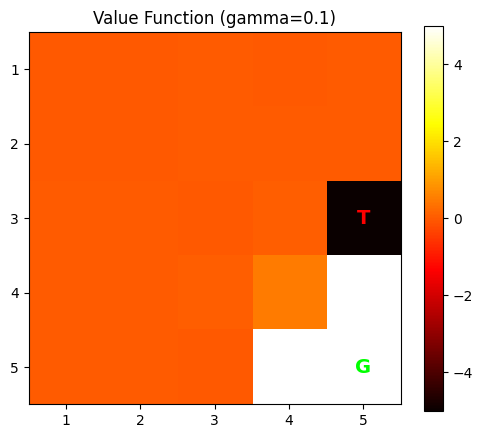

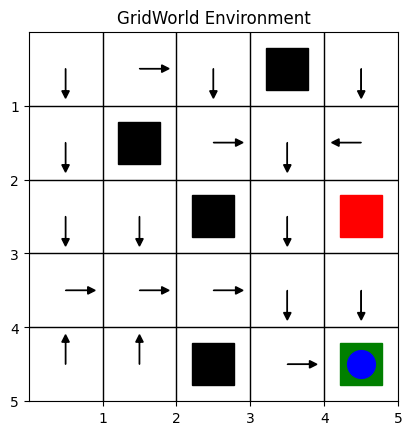

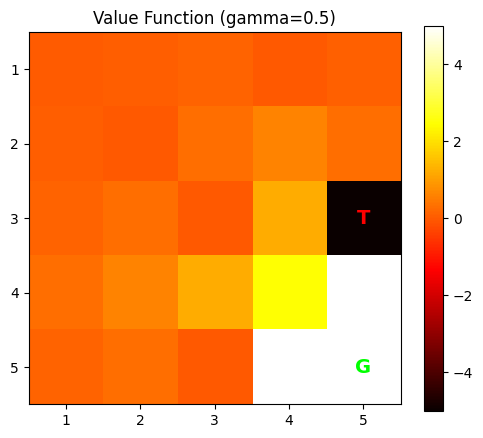

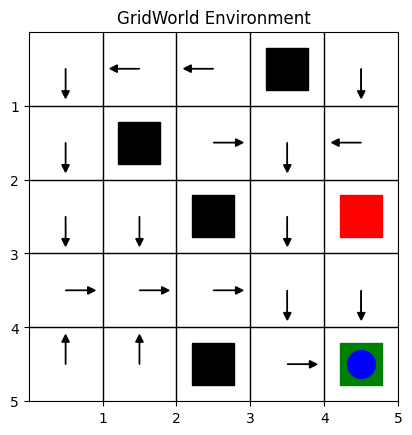

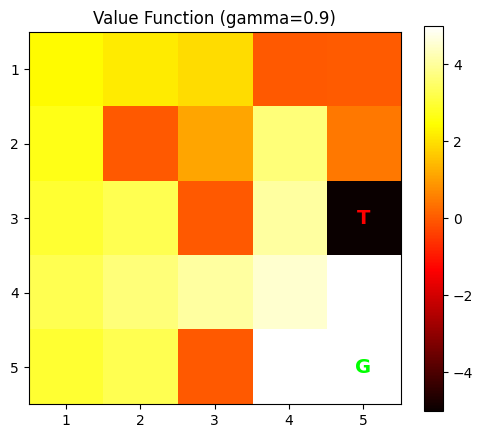

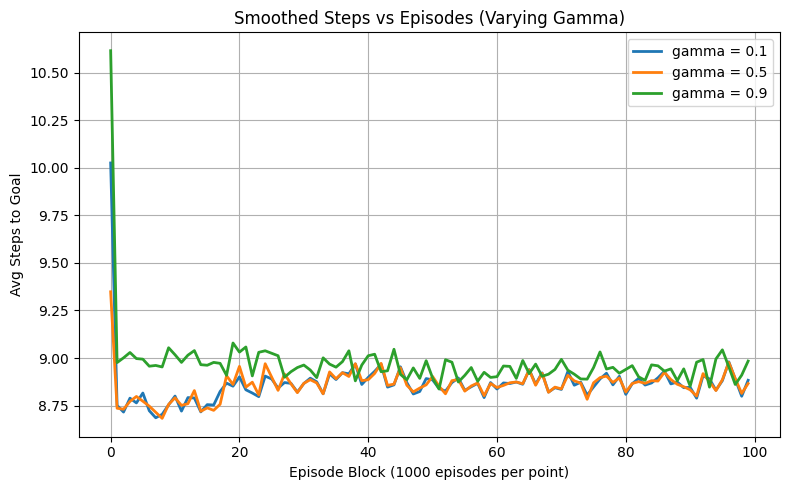

In [ ]:
gamma_values = [0.1, 0.5, 0.9]
all_steps = {}
for gamma in gamma_values:
    env = create_env(n, n, goal_state, trap_state, obstacle_states)
    Q, steps = train_q_learning(env, gamma=gamma, epsilon=0.1)
    policy, value_fn = extract_policy_and_value(Q, env)
    env.plot_grid(policy, plot_policy_flag=True)
    print()
    plot_value_function(value_fn, env, title=f"Value Function (gamma={gamma})")
    print()
    all_steps[gamma] = steps

plt.figure(figsize=(8, 5))
for gamma, steps in all_steps.items():
    avg_steps = moving_average(steps, window=1000)
    plt.plot(avg_steps, label=f"gamma = {gamma}", linewidth=2)
plt.title("Smoothed Steps vs Episodes (Varying Gamma)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 3: Varying Epsilon and Fixed Gamma 0.9

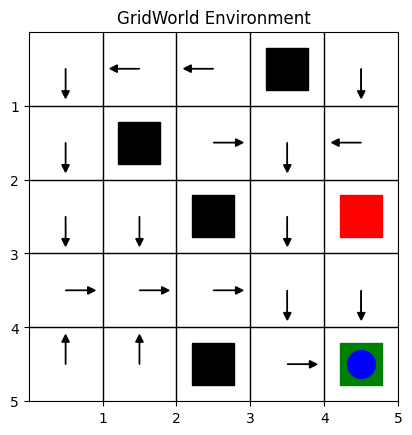

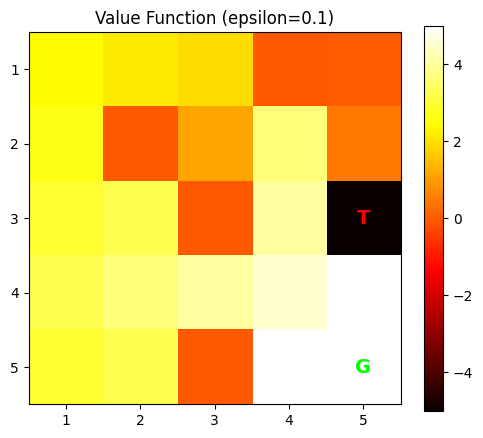

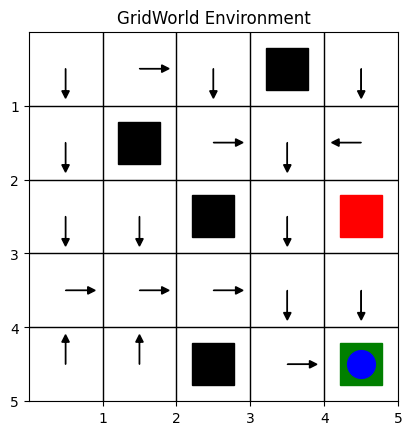

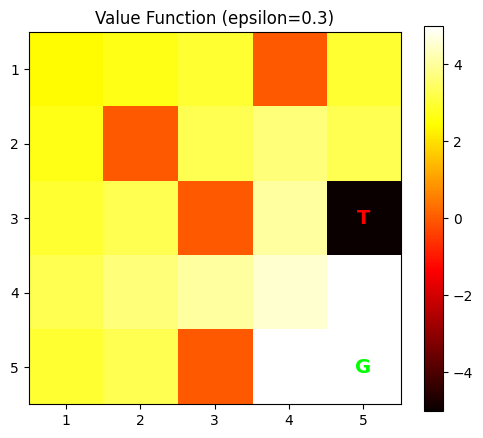

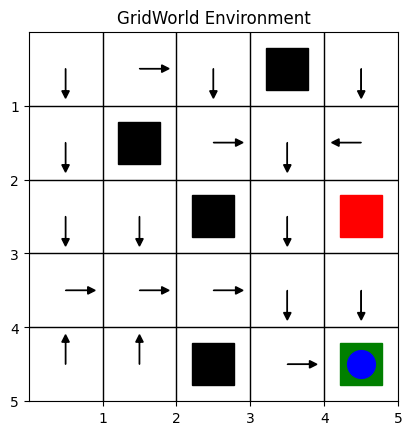

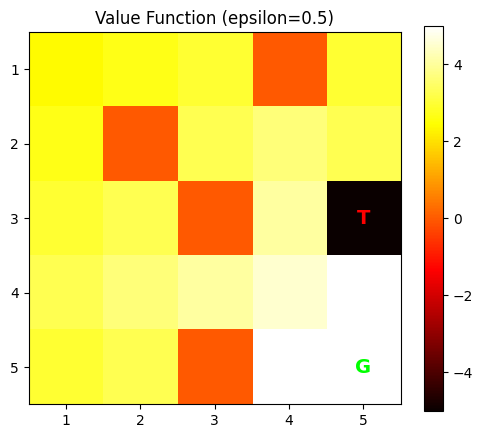

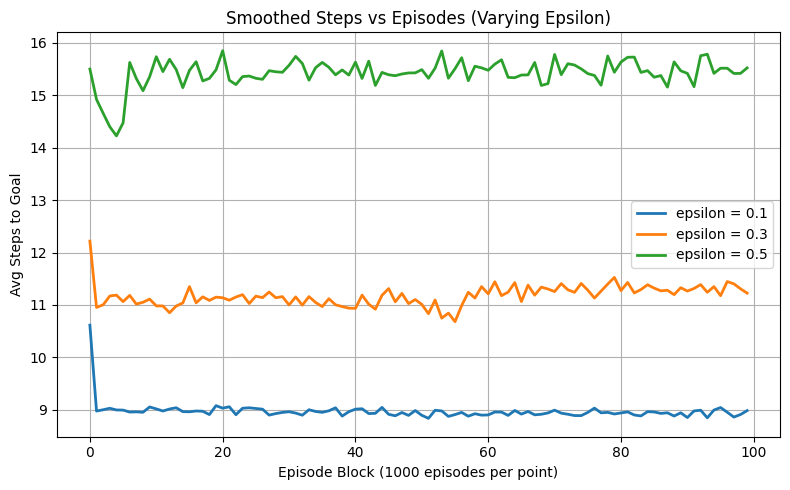

In [ ]:
epsilon_values = [0.1, 0.3, 0.5]
all_eps_steps = {}
for eps in epsilon_values:
    env = create_env(n, n, goal_state, trap_state, obstacle_states)
    Q, steps = train_q_learning(env, gamma=0.9, epsilon=eps)
    policy, value_fn = extract_policy_and_value(Q, env)
    env.plot_grid(policy, plot_policy_flag=True)
    print()
    plot_value_function(value_fn, env, title=f"Value Function (epsilon={eps})")
    print()
    all_eps_steps[eps] = steps

plt.figure(figsize=(8, 5))
for eps, steps in all_eps_steps.items():
    avg_steps = moving_average(steps, window=1000)
    plt.plot(avg_steps, label=f"epsilon = {eps}", linewidth=2)
plt.title("Smoothed Steps vs Episodes (Varying Epsilon)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Assignment Part 2 Setup

In [ ]:
grid_rows = 5
grid_cols = 10
num_episodes = 200000
part2_goal_state = [5, 10]
part2_trap_state = [4, 6]

part2_obstacle_states = [
    [2, 3],
    [3, 3],
    [4, 3],
    [3, 8],
    [3, 9],
    [5, 8],
]

## Question 1: Final Value Function & Policy

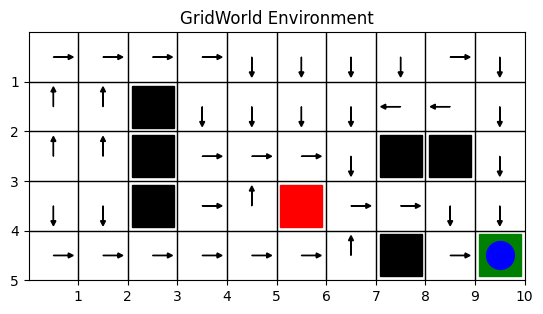

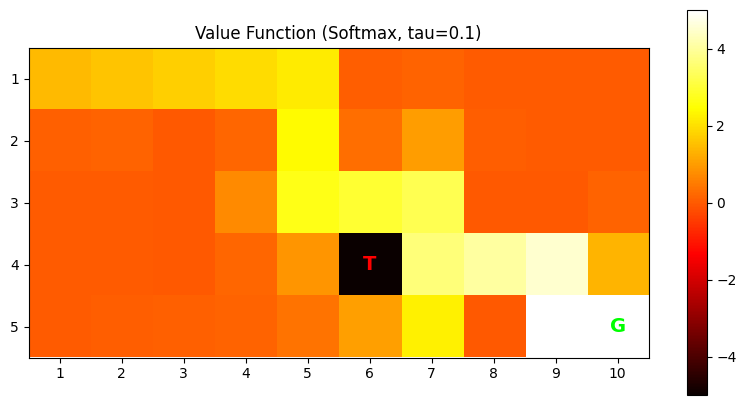

In [ ]:
part2_q1_env = create_env(grid_rows, grid_cols, part2_goal_state, part2_trap_state, part2_obstacle_states)

part2_Q1, part2_steps1 = train_q_softmax(
    part2_q1_env,
    num_episodes=num_episodes,
    alpha=0.1,
    gamma=0.9,
    tau=0.1,
    seed=1,
)
part2_policy1, part2_value_fn1 = extract_policy_and_value(part2_Q1, part2_q1_env)

part2_q1_env.plot_grid(part2_policy1, plot_policy_flag=True)
print()
plot_value_function(part2_value_fn1, part2_q1_env, title="Value Function (Softmax, tau=0.1)", figsize=(10, 5))

## Question 2: Varying Gamma

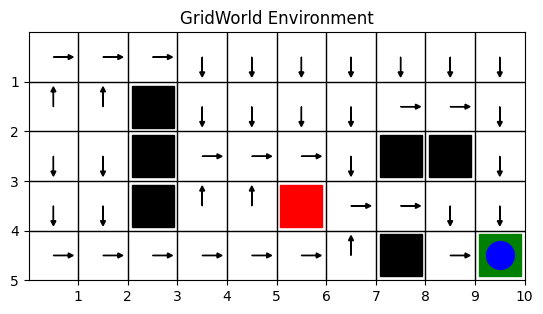

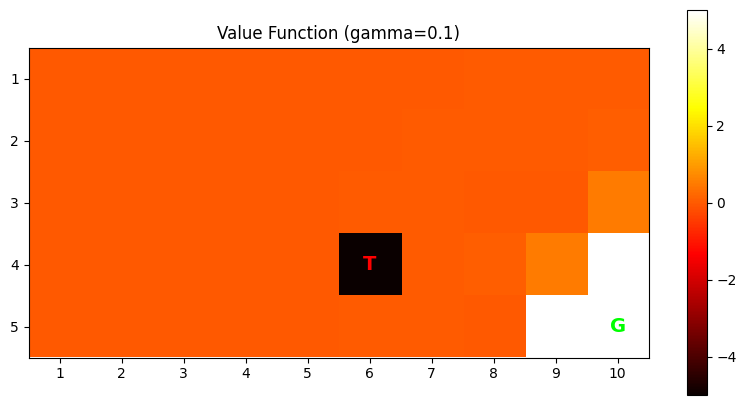

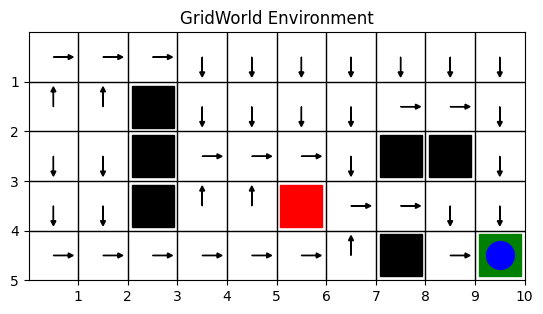

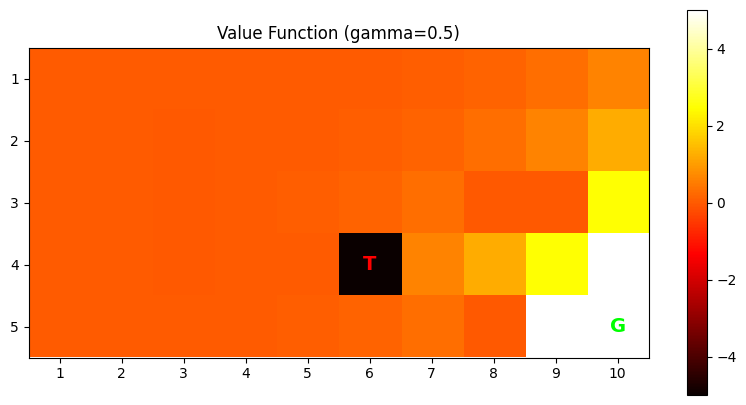

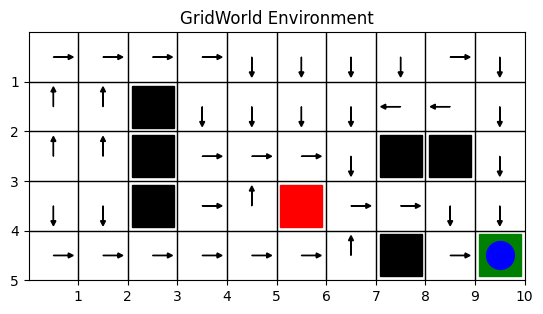

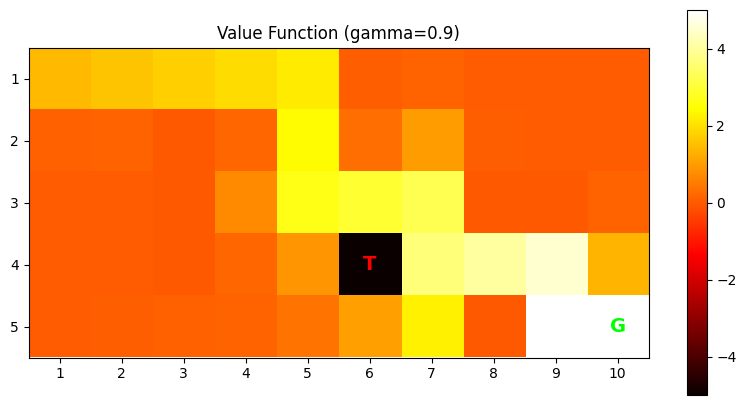

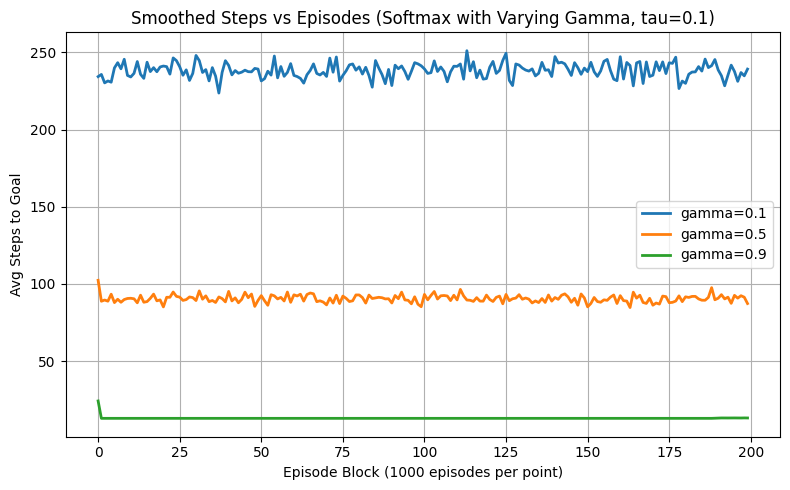

In [ ]:
gamma_values = [0.1, 0.5, 0.9]
all_steps = {}
for gamma in gamma_values:
    env = create_env(grid_rows, grid_cols, part2_goal_state, part2_trap_state, part2_obstacle_states)
    Q, steps = train_q_softmax(
        env,
        num_episodes=num_episodes,
        alpha=0.1,
        gamma=gamma,
        tau=0.1,
        seed=1,
    )
    policy, value_fn = extract_policy_and_value(Q, env)
    env.plot_grid(policy, plot_policy_flag=True)
    print()
    plot_value_function(value_fn, env, title=f"Value Function (gamma={gamma})", figsize=(10, 5))
    print()
    all_steps[gamma] = steps

plt.figure(figsize=(8, 5))
for gamma, steps in all_steps.items():
    avg_steps = moving_average(steps, window=1000)
    plt.plot(avg_steps, label=f"gamma={gamma}", linewidth=2)
plt.title("Smoothed Steps vs Episodes (Softmax with Varying Gamma, tau=0.1)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 3: Varying Tau

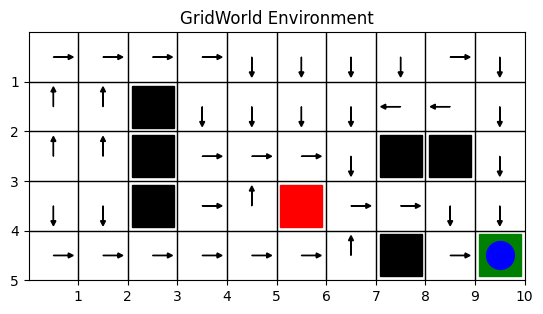

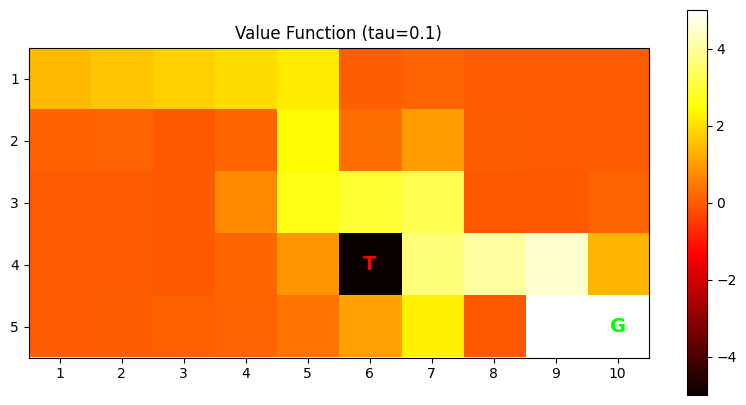

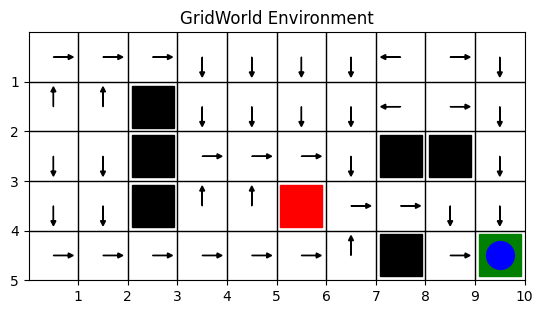

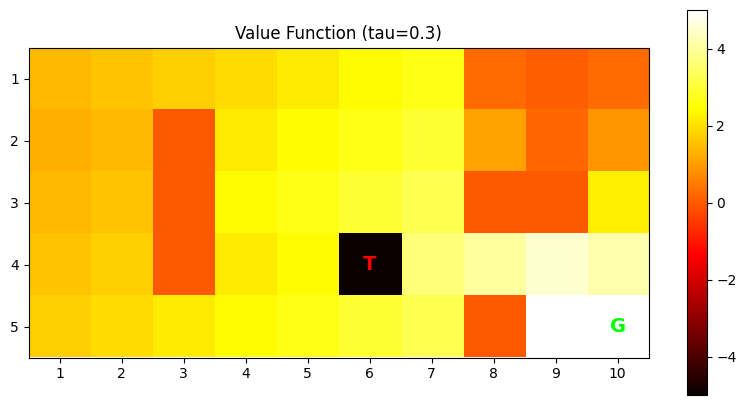

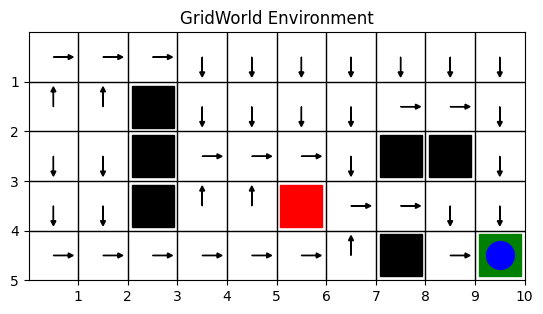

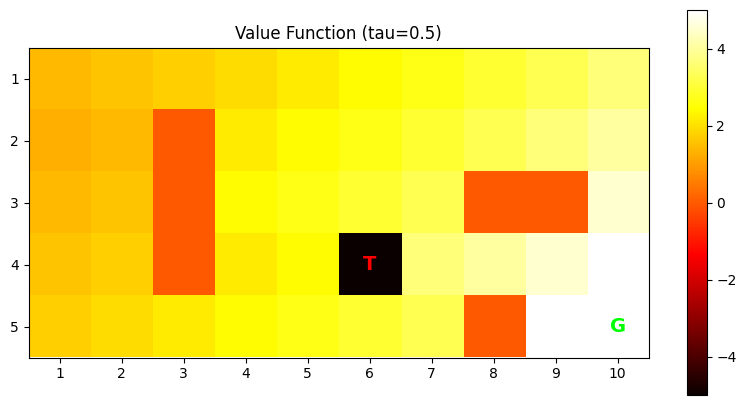

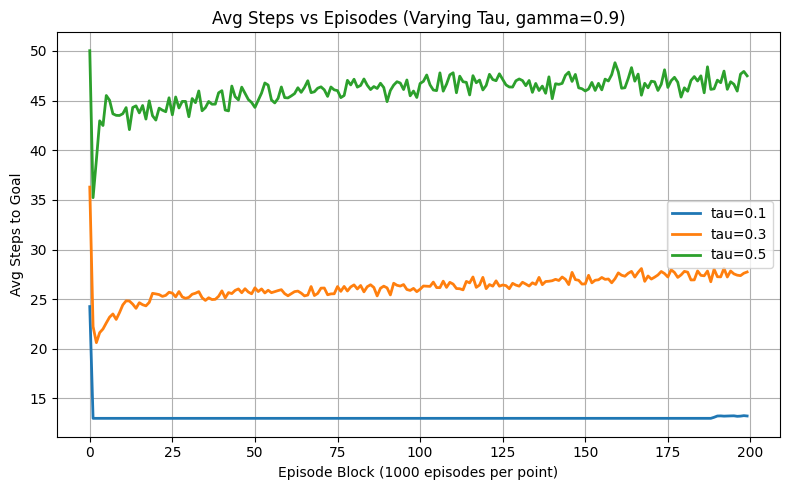

In [ ]:
tau_values = [0.1, 0.3, 0.5]
all_steps = {}
for tau in tau_values:
    env = create_env(grid_rows, grid_cols, part2_goal_state, part2_trap_state, part2_obstacle_states)
    Q, steps = train_q_softmax(
        env,
        num_episodes=num_episodes,
        alpha=0.1,
        gamma=0.9,
        tau=tau,
        seed=1,
    )
    policy, value_fn = extract_policy_and_value(Q, env)
    env.plot_grid(policy, plot_policy_flag=True)
    print()
    plot_value_function(value_fn, env, title=f"Value Function (tau={tau})", figsize=(10, 5))
    print()
    all_steps[tau] = steps

plt.figure(figsize=(8, 5))
for tau, steps in all_steps.items():
    avg_steps = moving_average(steps, window=1000)
    plt.plot(avg_steps, label=f"tau={tau}", linewidth=2)

plt.title("Avg Steps vs Episodes (Varying Tau, gamma=0.9)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()